# 基于卷积神经网络的手写英文字母识别系统研究

## 准备数据集及数据预处理

### 将下载的数据集按类重命名

In [1]:

# import os
# import string
#
# # 定义源目录路径
# source_dir = "EnglishHnd/EnglishHnd/English/Hnd/Img"
#
# # 生成目标文件夹名称列表
# target_folders = list(string.digits) + list(string.ascii_uppercase) + [f"{char}_" for char in string.ascii_lowercase]
#
# # 获取源目录下的所有文件夹名称
# source_folders = sorted([f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))])
#
# # 确保源文件夹数量与目标文件夹数量一致
# if len(source_folders) != len(target_folders):
#     raise ValueError("源文件夹数量与目标文件夹数量不一致")
#
# # 重命名文件夹
# for source_folder, target_folder in zip(source_folders, target_folders):
#     source_path = os.path.join(source_dir, source_folder)
#     target_path = os.path.join(source_dir, target_folder)
#
#     try:
#         os.rename(source_path, target_path)
#         print(f"重命名: {source_path} -> {target_path}")
#     except FileExistsError:
#         print(f"目标文件夹 {target_path} 已存在，跳过重命名 {source_path}")
#     except Exception as e:
#         print(f"重命名 {source_path} 到 {target_path} 时出错: {e}")


### 划分训练集和测试集

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
#数据增强
from albumentations.pytorch import ToTensorV2
import albumentations as A
from myCnn.baseline.LeNet5 import LeNet5
from myCnn.train_model import train_model
from myCnn.utils import split_dataset
from myCnn.baseline.resnet18 import resnet18
from myCnn.baseline.mobilenet_v2 import mobilenet_v2
from myCnn.evaluate_model import evaluate_model
from myCnn.utils import plot_comparison
EPOCH = 100
BATCH_SIZE = 128
LR = 1e-4

In [3]:
# # 定义数据预处理变换
# transform = T.Compose([
#     T.Resize((64, 64)),
#     T.Grayscale(num_output_channels=3),
#     T.RandomRotation(15),  # 数据增强：随机旋转
#     T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 位移
#     T.ToTensor(),
#     # 如果需要标准化，可以取消注释以下行
#     T.Normalize([0.5], [0.5])
# ])
class AlbumentationsTransform:
    def __init__(self):
        self.transform=A.Compose([
            A.Resize(28, 28),
            A.Rotate(limit=15, p=0.5),
            A.Affine(translate_percent=(0.1,0.1),p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=(0.5,),std=(0.5,)),
            ToTensorV2()
        ])
    def __call__(self, img):
        img=np.array(img)
        # img = np.array(img.convert('L'))
        return self.transform(image=img)['image']

transform=AlbumentationsTransform()


训练集大小: 25900
验证集大小: 5550
测试集大小: 5550
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'a_': 26, 'b_': 27, 'd_': 28, 'e_': 29, 'f_': 30, 'g_': 31, 'h_': 32, 'n_': 33, 'q_': 34, 'r_': 35, 't_': 36}


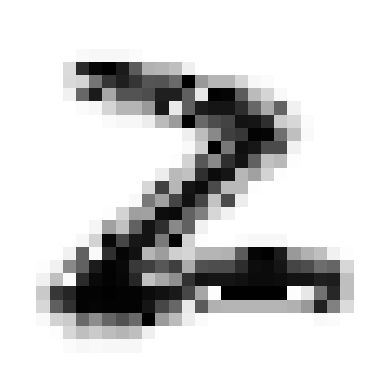

In [4]:
# 使用函数划分数据集
train_loader, val_loader, test_loader, full_dataset = split_dataset(
    root_dir="emnist_png_balanced",
    # root_dir="EnglishImg/EnglishImg/English/Img/GoodImg/Bmp",
    transform=transform,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    batch_size=BATCH_SIZE,
    shuffle=True,
    random_seed=42
)

# 打印数据集大小
print(f"训练集大小: {len(train_loader.dataset)}")
print(f"验证集大小: {len(val_loader.dataset)}")
print(f"测试集大小: {len(test_loader.dataset)}")

# 获取类别数量
label_num = len(full_dataset.class_to_idx)
print(full_dataset.class_to_idx)
# 数据可视化
to_img = T.ToPILImage()
a = to_img(train_loader.dataset[0][0])  # size=[1, 28, 28]
plt.imshow(a)
plt.axis('off')
plt.show()


# 获取类别数量
label_num = len(full_dataset.class_to_idx)

In [5]:

# # 获取展平后的训练集和验证集
# X_train, y_train = flatten_images(train_loader)
# X_val, y_val = flatten_images(val_loader)

In [6]:

# # 训练SVM模型
# svm_clf, train_acc, val_acc = train_svm(X_train, y_train, X_val, y_val)

In [5]:

# 初始化模型
resnet18 = resnet18(num_classes=label_num)
mobilenet_v2 = mobilenet_v2(num_classes=label_num)
LeNet5 = LeNet5(num_classes=label_num)

# 加载最好的权重模型

resnet18.load_state_dict(torch.load('best_model_resnet18.pth'))
mobilenet_v2.load_state_dict(torch.load('best_model_mobilenet_v2.pth'))
LeNet5.load_state_dict(torch.load('best_model_LeNet5.pth'))


# 检查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)  # 将模型迁移到 GPU
mobilenet_v2.to(device)
LeNet5.to(device)

# 假设使用cpu
# cnn.to('cpu')

# 创建优化器
optimizer_resnet18 = torch.optim.AdamW(resnet18.parameters(), lr=3e-4, weight_decay=0.05)
optimizer_mobilenet_v2 = torch.optim.AdamW(mobilenet_v2.parameters(), lr=3e-4, weight_decay=0.05)
optimizer_LeNet5 = torch.optim.AdamW(LeNet5.parameters(), lr=3e-4, weight_decay=0.05)



# 定义损失函数
loss_func = nn.CrossEntropyLoss()

Using device: cuda
Starting training...
Epoch [1/30], Train Loss: 1.0442, Train Top-1: 69.93%, Train Top-3: 87.55%, | Val Loss: 0.5324, Val Top-1: 83.42%, Val Top-3: 96.47%
Epoch [2/30], Train Loss: 0.4547, Train Top-1: 85.32%, Train Top-3: 97.24%, | Val Loss: 0.4227, Val Top-1: 86.11%, Val Top-3: 97.28%
Epoch [3/30], Train Loss: 0.3620, Train Top-1: 87.82%, Train Top-3: 98.24%, | Val Loss: 0.3700, Val Top-1: 87.46%, Val Top-3: 98.27%
Epoch [4/30], Train Loss: 0.3158, Train Top-1: 89.08%, Train Top-3: 98.66%, | Val Loss: 0.3547, Val Top-1: 87.71%, Val Top-3: 98.32%
Epoch [5/30], Train Loss: 0.2898, Train Top-1: 89.81%, Train Top-3: 98.97%, | Val Loss: 0.3331, Val Top-1: 88.59%, Val Top-3: 98.29%
Epoch [6/30], Train Loss: 0.2656, Train Top-1: 90.81%, Train Top-3: 99.05%, | Val Loss: 0.3253, Val Top-1: 89.15%, Val Top-3: 98.52%
Epoch [7/30], Train Loss: 0.2505, Train Top-1: 91.24%, Train Top-3: 99.23%, | Val Loss: 0.3150, Val Top-1: 89.39%, Val Top-3: 98.74%
Epoch [8/30], Train Loss: 0.2

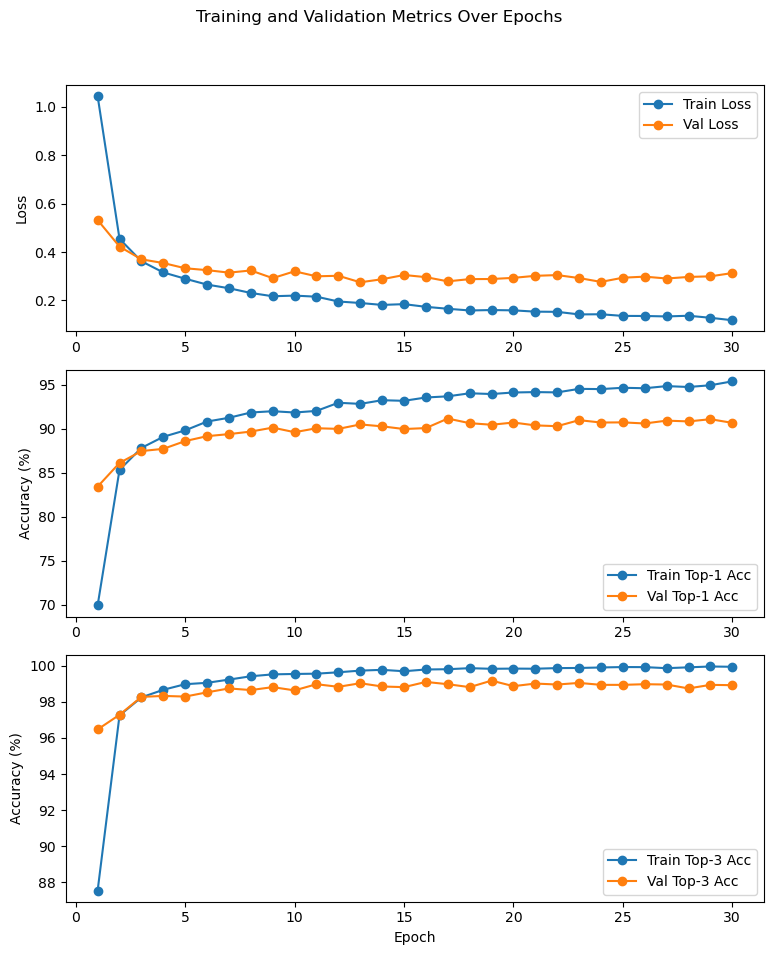

Saved final training metrics plot to training_plots\20250422_204048_training_metrics.png
Final model saved to best_model_resnet18.pth


In [8]:
# 训练模型
resnet18 = train_model(resnet18, train_loader, val_loader, loss_func, optimizer_resnet18, save_path="best_model_resnet18.pth", num_epochs=30)



Using device: cuda
Starting training...
Epoch [1/30], Train Loss: 3.2370, Train Top-1: 11.74%, Train Top-3: 26.24%, | Val Loss: 2.6064, Val Top-1: 24.07%, Val Top-3: 49.03%
Epoch [2/30], Train Loss: 2.1204, Train Top-1: 36.63%, Train Top-3: 64.11%, | Val Loss: 1.6506, Val Top-1: 48.67%, Val Top-3: 77.44%
Epoch [3/30], Train Loss: 1.4071, Train Top-1: 56.27%, Train Top-3: 82.34%, | Val Loss: 1.1374, Val Top-1: 64.09%, Val Top-3: 87.64%
Epoch [4/30], Train Loss: 1.0490, Train Top-1: 66.81%, Train Top-3: 89.24%, | Val Loss: 0.9093, Val Top-1: 71.17%, Val Top-3: 91.14%
Epoch [5/30], Train Loss: 0.8436, Train Top-1: 73.13%, Train Top-3: 92.66%, | Val Loss: 0.7344, Val Top-1: 75.91%, Val Top-3: 94.23%
Epoch [6/30], Train Loss: 0.7082, Train Top-1: 77.16%, Train Top-3: 94.33%, | Val Loss: 0.6447, Val Top-1: 79.64%, Val Top-3: 94.74%
Epoch [7/30], Train Loss: 0.6260, Train Top-1: 79.87%, Train Top-3: 95.39%, | Val Loss: 0.5968, Val Top-1: 80.47%, Val Top-3: 95.73%
Epoch [8/30], Train Loss: 0.5

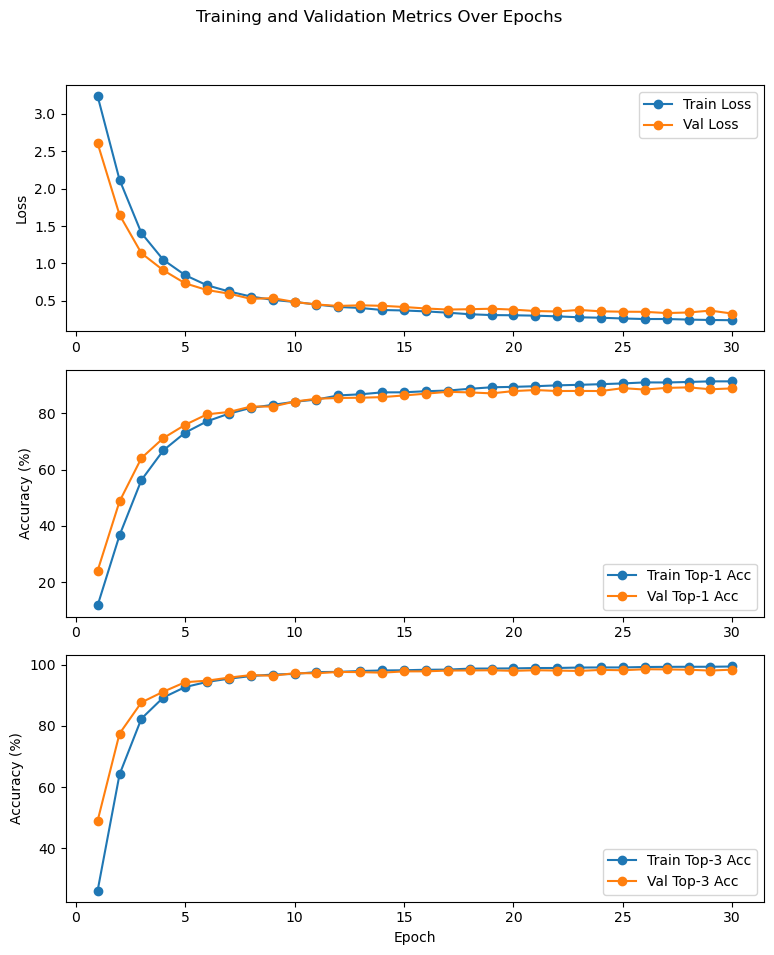

Saved final training metrics plot to training_plots\20250422_204813_training_metrics.png
Final model saved to best_model_mobilenet_v2.pth


In [9]:
mobilenet_v2 = train_model(mobilenet_v2, train_loader, val_loader, loss_func, optimizer_mobilenet_v2, save_path="best_model_mobilenet_v2.pth", num_epochs=30)


Using device: cuda
Starting training...
Epoch [1/30], Train Loss: 2.8309, Train Top-1: 22.81%, Train Top-3: 42.31%, | Val Loss: 2.0493, Val Top-1: 43.05%, Val Top-3: 67.75%
Epoch [2/30], Train Loss: 1.7744, Train Top-1: 50.02%, Train Top-3: 74.36%, | Val Loss: 1.5661, Val Top-1: 55.35%, Val Top-3: 78.68%
Epoch [3/30], Train Loss: 1.4088, Train Top-1: 60.01%, Train Top-3: 82.12%, | Val Loss: 1.2506, Val Top-1: 63.95%, Val Top-3: 85.17%
Epoch [4/30], Train Loss: 1.1452, Train Top-1: 67.11%, Train Top-3: 87.19%, | Val Loss: 1.0138, Val Top-1: 70.47%, Val Top-3: 89.05%
Epoch [5/30], Train Loss: 0.9596, Train Top-1: 72.02%, Train Top-3: 90.33%, | Val Loss: 0.8677, Val Top-1: 74.54%, Val Top-3: 91.55%
Epoch [6/30], Train Loss: 0.8520, Train Top-1: 75.12%, Train Top-3: 92.00%, | Val Loss: 0.7904, Val Top-1: 76.85%, Val Top-3: 92.83%
Epoch [7/30], Train Loss: 0.7644, Train Top-1: 77.38%, Train Top-3: 93.28%, | Val Loss: 0.7152, Val Top-1: 79.26%, Val Top-3: 93.59%
Epoch [8/30], Train Loss: 0.7

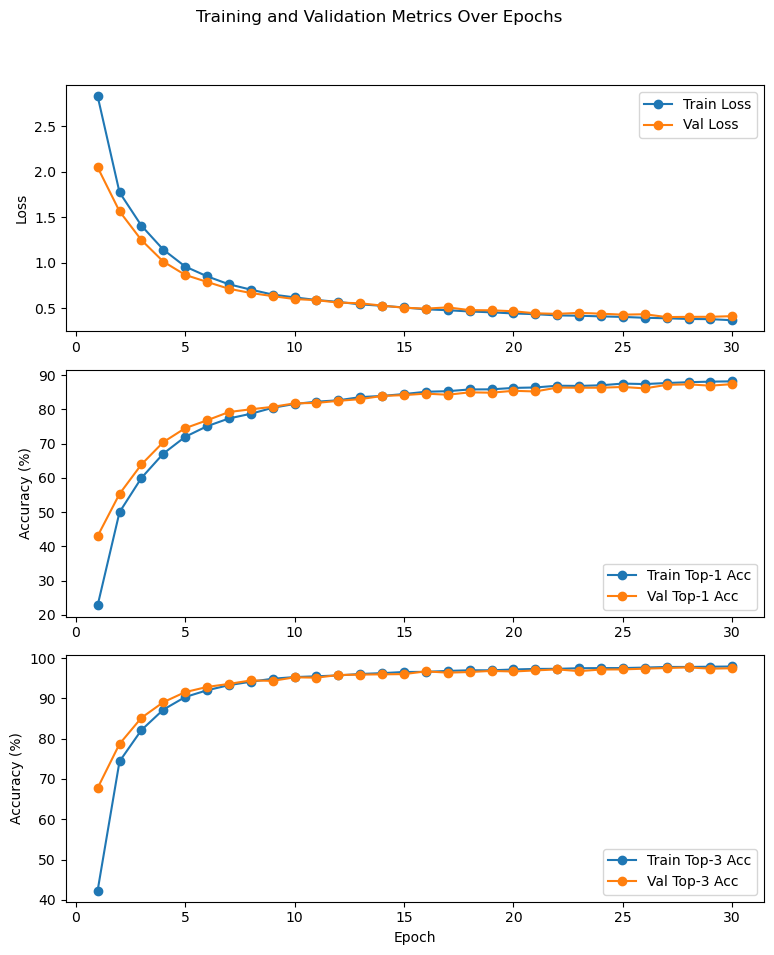

Saved final training metrics plot to training_plots\20250422_205410_training_metrics.png
Final model saved to best_model_LeNet5.pth


In [10]:
LeNet5 = train_model(LeNet5, train_loader, val_loader, loss_func, optimizer_LeNet5, save_path="best_model_LeNet5.pth",num_epochs=30)

In [11]:
# 模型大小
model_size_resnet18 = sum(p.numel() for p in resnet18.parameters())
model_size_mobilenet_v2 = sum(p.numel() for p in mobilenet_v2.parameters())
model_size_LeNet5 = sum(p.numel() for p in LeNet5.parameters())
# 打印模型大小
print(f"ResNet18 Model Size: {model_size_resnet18} parameters")
print(f"MobileNetV2 Model Size: {model_size_mobilenet_v2} parameters")
print(f"LeNet5 Model Size: {model_size_LeNet5} parameters")

model_sizes = [model_size_resnet18, model_size_mobilenet_v2, model_size_LeNet5]
model_names = ["ResNet18", "MobileNetV2", "LeNet5"]
top1_accs = []
top3_accs = []
inference_speeds = []

ResNet18 Model Size: 11195493 parameters
MobileNetV2 Model Size: 2271269 parameters
LeNet5 Model Size: 47021 parameters


Confusion matrix, without normalization


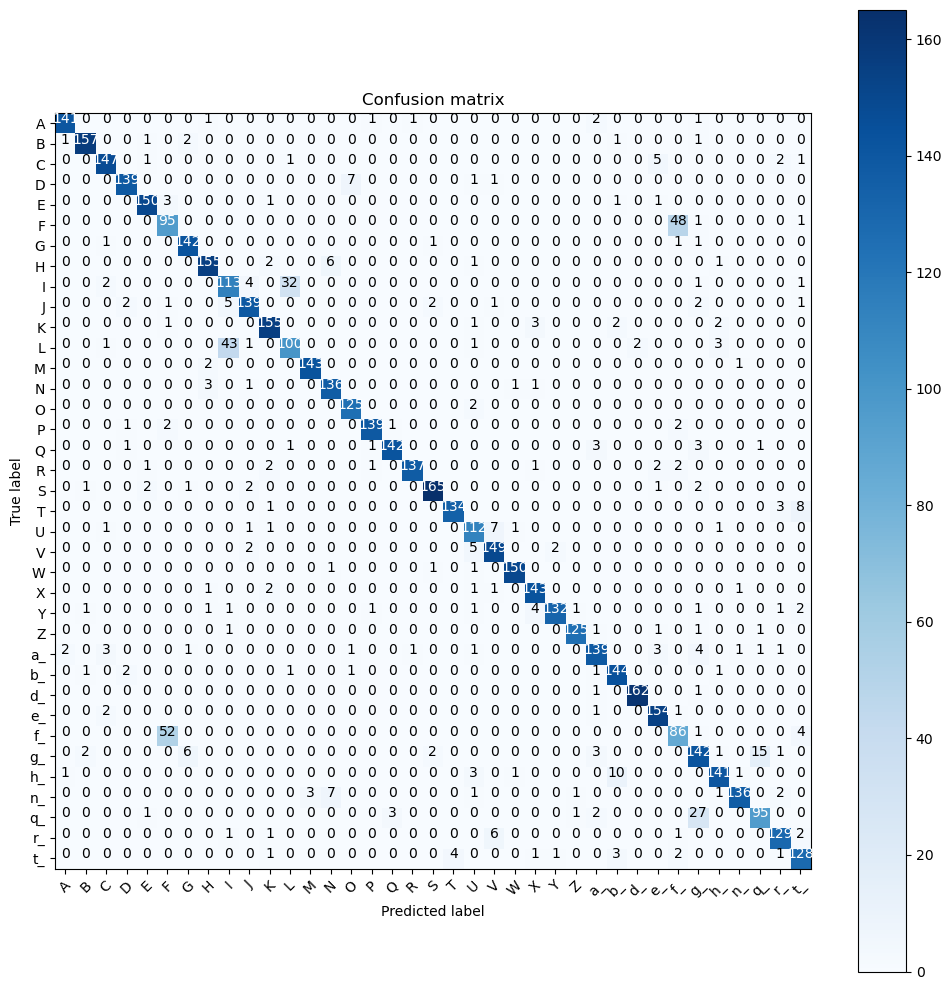

ResNet18 Evaluation:
Top-1 Accuracy: 90.4685
Top-3 Accuracy: 98.9550
Inference Speed: 0.0442 ms per sample


In [7]:
# 推理
top1_acc_resnet18, top3_acc_resnet18, inference_speed_resnet18 = evaluate_model(resnet18, test_loader, device)
top1_accs.append(top1_acc_resnet18)
top3_accs.append(top3_acc_resnet18)
inference_speeds.append(inference_speed_resnet18)
print("ResNet18 Evaluation:")
print(f"Top-1 Accuracy: {top1_acc_resnet18:.4f}")
print(f"Top-3 Accuracy: {top3_acc_resnet18:.4f}")
print(f"Inference Speed: {inference_speed_resnet18 * 1000:.4f} ms per sample")

Confusion matrix, without normalization


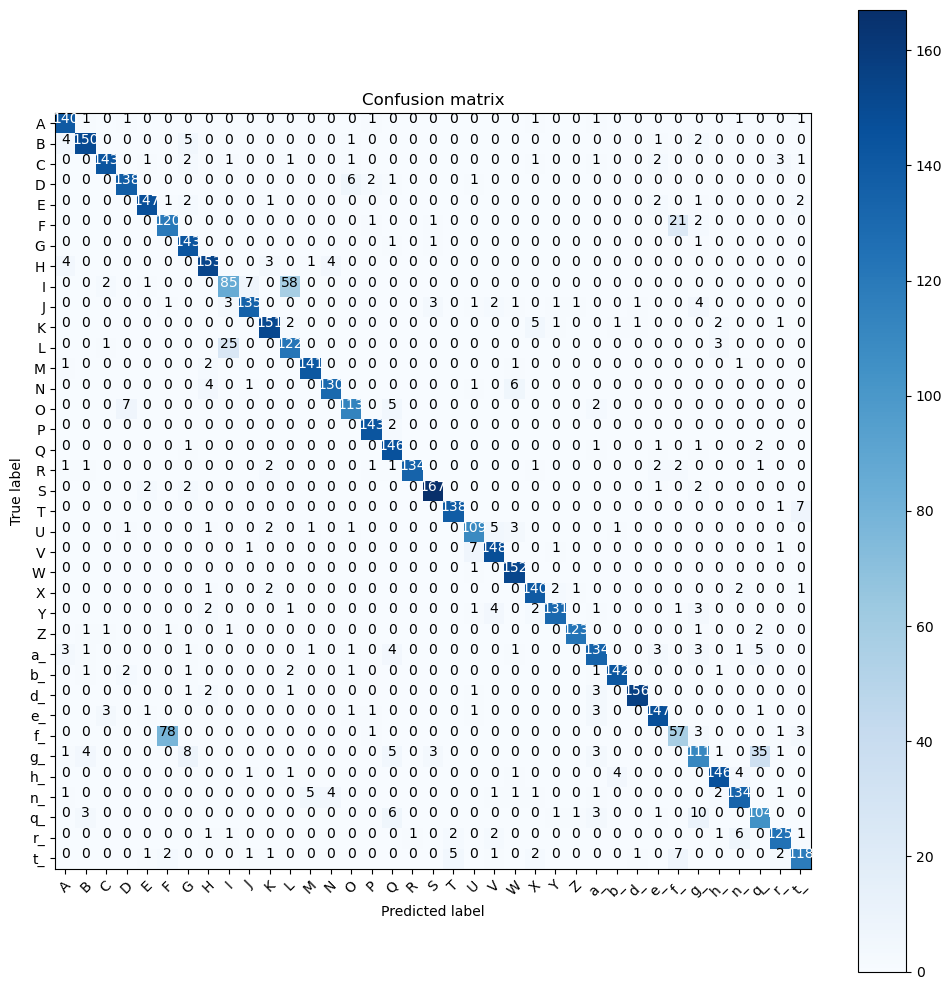

MobileNetV2 Evaluation:
Top-1 Accuracy: 88.5766
Top-3 Accuracy: 98.4685
Inference Speed: 0.0308 ms per sample


In [8]:
top1_acc_mobilenetv2, top3_acc_mobilenetv2, inference_speed_mobilenetv2 = evaluate_model(mobilenet_v2, test_loader, device)
top1_accs.append(top1_acc_mobilenetv2)
top3_accs.append(top3_acc_mobilenetv2)
inference_speeds.append(inference_speed_mobilenetv2)
print("MobileNetV2 Evaluation:")
print(f"Top-1 Accuracy: {top1_acc_mobilenetv2:.4f}")
print(f"Top-3 Accuracy: {top3_acc_mobilenetv2:.4f}")
print(f"Inference Speed: {inference_speed_mobilenetv2 * 1000:.4f} ms per sample")

Confusion matrix, without normalization


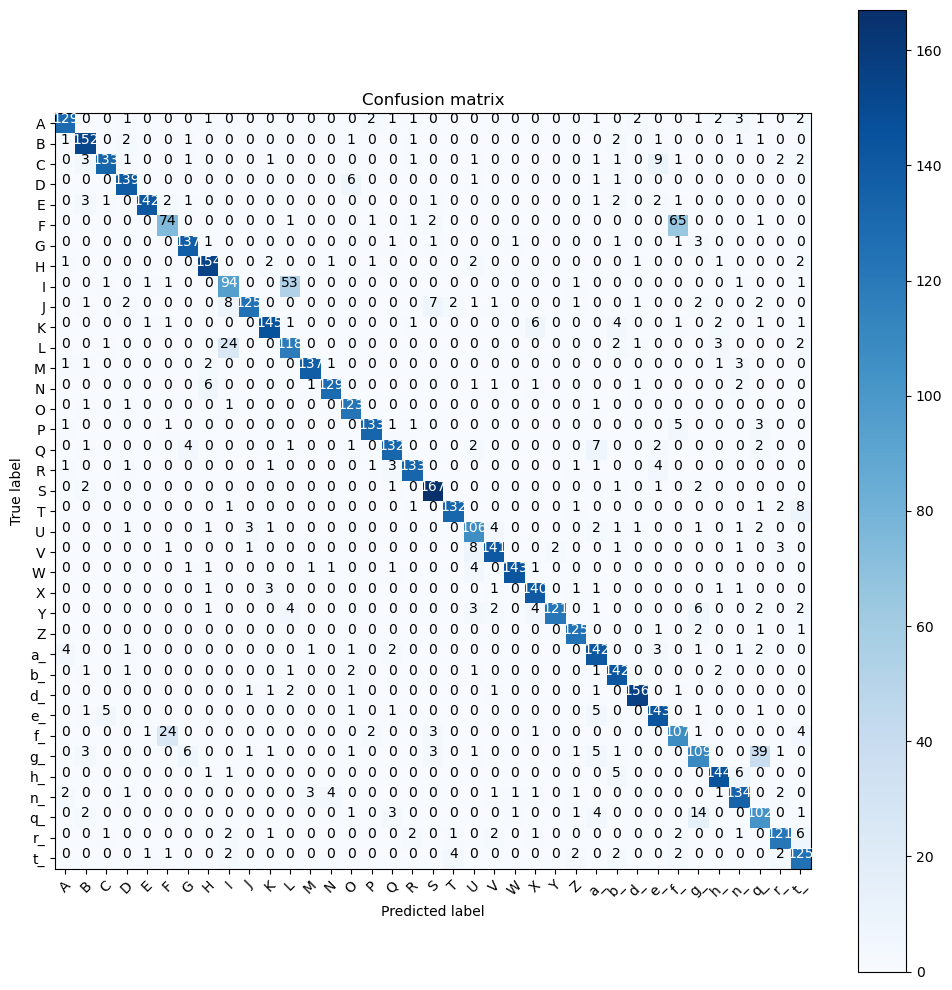

LeNet5 Evaluation:
Top-1 Accuracy: 87.009009009009
Top-3 Accuracy: 97.36936936936937
Inference Speed: 0.00047288499436936936


In [9]:
top1_acc_LeNet5, top3_acc_LeNet5, inference_speed_LeNet5 = evaluate_model(LeNet5, test_loader, device)
top1_accs.append(top1_acc_LeNet5)
top3_accs.append(top3_acc_LeNet5)
inference_speeds.append(inference_speed_LeNet5)
print("LeNet5 Evaluation:")
print(f"Top-1 Accuracy: {top1_acc_LeNet5}")
print(f"Top-3 Accuracy: {top3_acc_LeNet5}")
print(f"Inference Speed: {inference_speed_LeNet5 * 100}")

E:\计算智能\myCnn\utils.py:94: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
E:\计算智能\myCnn\utils.py:94: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
E:\计算智能\myCnn\utils.py:94: UserWarning: Glyph 21517 (\N{CJK UNIFIED IDEOGRAPH-540D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
E:\计算智能\myCnn\utils.py:94: UserWarning: Glyph 31216 (\N{CJK UNIFIED IDEOGRAPH-79F0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
E:\计算智能\myCnn\utils.py:94: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
E:\计算智能\myCnn\utils.py:94: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
E:\计算智能\myCnn\utils.py:94: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
E:\计算智能\myCnn\utils.

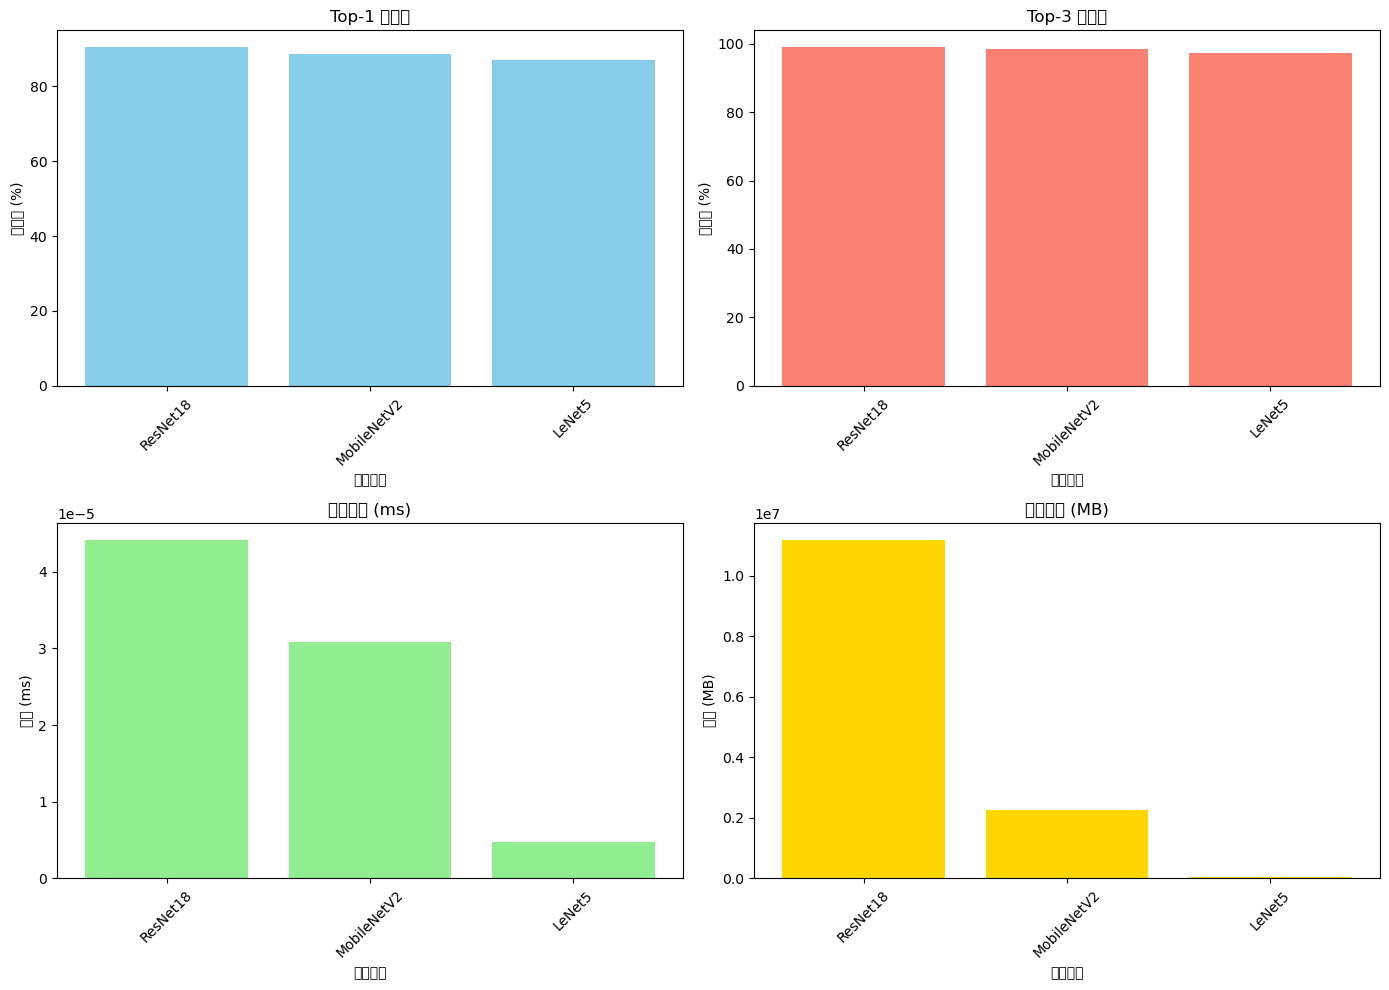

In [10]:
plot_comparison(model_names, top1_accs, top3_accs, inference_speeds, model_sizes)
